## Demonstration of optimization of GTM hyperparameters with k3nerror
# Hiromasa Kaneko

In [1]:
import matplotlib.figure as figure
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

from gtm import GTM
from k3nerror import k3nerror

In [2]:
# settings
candidates_of_shape_of_map = np.arange(30, 31, dtype=int)
candidates_of_shape_of_rbf_centers = np.arange(2, 22, 2, dtype=int)
candidates_of_variance_of_rbfs = 2 ** np.arange(-5, 4, 2, dtype=float)
candidates_of_lambda_in_em_algorithm = 2 ** np.arange(-4, 0, dtype=float)
candidates_of_lambda_in_em_algorithm = np.append(0, candidates_of_lambda_in_em_algorithm)
number_of_iterations = 300
display_flag = 0
k_in_k3nerror = 10

In [3]:
# load an iris dataset
iris = load_iris()
# input_dataset = pd.DataFrame(iris.data, columns=iris.feature_names)
input_dataset = iris.data
color = iris.target

In [4]:
# autoscaling
input_dataset = (input_dataset - input_dataset.mean(axis=0)) / input_dataset.std(axis=0, ddof=1)

In [5]:
# grid search
parameters_and_k3nerror = []
all_calculation_numbers = len(candidates_of_shape_of_map) * len(candidates_of_shape_of_rbf_centers) * len(
    candidates_of_variance_of_rbfs) * len(candidates_of_lambda_in_em_algorithm)
calculation_number = 0
for shape_of_map_grid in candidates_of_shape_of_map:
    for shape_of_rbf_centers_grid in candidates_of_shape_of_rbf_centers:
        for variance_of_rbfs_grid in candidates_of_variance_of_rbfs:
            for lambda_in_em_algorithm_grid in candidates_of_lambda_in_em_algorithm:
                calculation_number += 1
                print([calculation_number, all_calculation_numbers])
                # construct GTM model
                model = GTM([shape_of_map_grid, shape_of_map_grid],
                            [shape_of_rbf_centers_grid, shape_of_rbf_centers_grid],
                            variance_of_rbfs_grid, lambda_in_em_algorithm_grid, number_of_iterations, display_flag)
                model.fit(input_dataset)
                if model.success_flag:
                    # calculate of responsibilities
                    responsibilities = model.responsibility(input_dataset)
                    # calculate the mean of responsibilities
                    means = responsibilities.dot(model.map_grids)
                    # calculate k3n-error
                    k3nerror_of_gtm = k3nerror(input_dataset, means, k_in_k3nerror)
                else:
                    k3nerror_of_gtm = 10 ** 100
                parameters_and_k3nerror.append(
                    [shape_of_map_grid, shape_of_rbf_centers_grid, variance_of_rbfs_grid, lambda_in_em_algorithm_grid,
                     k3nerror_of_gtm])

[1, 250]
[2, 250]
[3, 250]
[4, 250]
[5, 250]
[6, 250]
[7, 250]
[8, 250]
[9, 250]
[10, 250]
[11, 250]
[12, 250]
[13, 250]
[14, 250]
[15, 250]
[16, 250]
[17, 250]
[18, 250]
[19, 250]
[20, 250]
[21, 250]
[22, 250]
[23, 250]
[24, 250]
[25, 250]
[26, 250]
[27, 250]
[28, 250]
[29, 250]
[30, 250]
[31, 250]
[32, 250]
[33, 250]
[34, 250]
[35, 250]
[36, 250]
[37, 250]
[38, 250]
[39, 250]
[40, 250]
[41, 250]
[42, 250]
[43, 250]
[44, 250]
[45, 250]
[46, 250]
[47, 250]
[48, 250]
[49, 250]
[50, 250]
[51, 250]
[52, 250]
[53, 250]
[54, 250]
[55, 250]
[56, 250]
[57, 250]
[58, 250]
[59, 250]
[60, 250]
[61, 250]
[62, 250]
[63, 250]
[64, 250]
[65, 250]
[66, 250]
[67, 250]
[68, 250]
[69, 250]
[70, 250]
[71, 250]
[72, 250]
[73, 250]
[74, 250]
[75, 250]
[76, 250]
[77, 250]
[78, 250]
[79, 250]
[80, 250]
[81, 250]
[82, 250]
[83, 250]
[84, 250]
[85, 250]
[86, 250]
[87, 250]
[88, 250]
[89, 250]
[90, 250]
[91, 250]
[92, 250]
[93, 250]
[94, 250]
[95, 250]
[96, 250]
[97, 250]
[98, 250]
[99, 250]
[100, 250]
[101, 25

In [6]:
# optimized GTM
parameters_and_k3nerror = np.array(parameters_and_k3nerror)
optimized_hyperparameter_number = \
    np.where(parameters_and_k3nerror[:, 4] == np.min(parameters_and_k3nerror[:, 4]))[0][0]
shape_of_map = [parameters_and_k3nerror[optimized_hyperparameter_number, 0],
                parameters_and_k3nerror[optimized_hyperparameter_number, 0]]
shape_of_rbf_centers = [parameters_and_k3nerror[optimized_hyperparameter_number, 1],
                        parameters_and_k3nerror[optimized_hyperparameter_number, 1]]
variance_of_rbfs = parameters_and_k3nerror[optimized_hyperparameter_number, 2]
lambda_in_em_algorithm = parameters_and_k3nerror[optimized_hyperparameter_number, 3]

In [7]:
# construct GTM model
model = GTM(shape_of_map, shape_of_rbf_centers, variance_of_rbfs, lambda_in_em_algorithm, number_of_iterations,
            display_flag)
model.fit(input_dataset)

In [8]:
# calculate of responsibilities
responsibilities = model.responsibility(input_dataset)

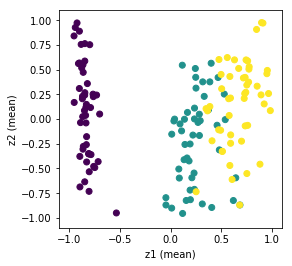

In [9]:
# plot the mean of responsibilities
means = responsibilities.dot(model.map_grids)
plt.figure(figsize=figure.figaspect(1))
plt.scatter(means[:, 0], means[:, 1], c=color)
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.xlabel("z1 (mean)")
plt.ylabel("z2 (mean)")
plt.show()

In [10]:
print("Optimized hyperparameters")
print("Optimal map size: {0}, {1}".format(shape_of_map[0], shape_of_map[1]))
print("Optimal shape of RBF centers: {0}, {1}".format(shape_of_rbf_centers[0], shape_of_rbf_centers[1]))
print("Optimal variance of RBFs: {0}".format(variance_of_rbfs))
print("Optimal lambda in EM algorithm: {0}".format(lambda_in_em_algorithm))

Optimized hyperparameters
Optimal map size: 30, 30
Optimal shape of RBF centers: 4, 4
Optimal variance of RBFs: 8.0
Optimal lambda in EM algorithm: 0.25
